### Closed form solution of Digital call option
Digital option is a type of exotic option whose payoff is either a fixed amount of money, a predetermined asset on the occurrence of a specific event or nothing.

There are two types of digital options: cash-or-nothing and asset-or-nothing.

In this work, we will focus on cash-or-nothing option whose value at maturity is 0 for $S(T) \leq K$ and $K$ when $S(T) > K$, for call option. Hence the price a of such call option at time  $t$ is given by
$$V(t, S(t)) = \mathbb{E}^\mathbb{Q}[K \mathbb{1}_{S(T) > K} | \mathcal{F}(t)] =  e^{-r\cdot (T-t)}K \mathbb{Q}(S(T) > K)$$ 
where $\mathbb{Q}$ is the risk-neutral probabality measure.

Therefore, the closed form solution of the cash-or-nothing `call option` under the Black-Sholes dynamics governed by the risk-neutral probability measure is given by 

$$V(t, S_t) =K \cdot e^{-r\cdot (T-t)}\cdot N(d_2)$$

Note that $N(d_2)$ gives the probability, under the risk-neutal measuer $\mathbb{Q}$, that the underlying asset price will be above the strike price at maturity.

with $$d_2 = \frac{\ln\left(\frac{S_t}{K}\right) + \left(r - \frac{\sigma^2}{2}\right)\cdot(T-t)}{\sigma\cdot\sqrt{T-t}},\quad  N(x) = \frac{1}{\sqrt{2\cdot\pi}}\cdot \int_{-\infty}^x e^{-\frac{u^2}{2}} du .$$

For a `put option`, the pay-off at maturity is 0 for $S(T) \geq K$ and $K$ when $S(T) < K$. This yields the put option price at time $t$ as 
$$V_{put}(t, S_t) =K \cdot e^{-r\cdot (T-t)}\cdot N(-d_2)$$

 $N(-d_2)$ gives the probability, under the risk-neutal measuer $\mathbb{Q}$, that the underlying asset price will be below the strike price at maturity.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm 
import scipy.stats as st
import enum 


In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 4)
np.random.seed(3)

In [3]:
class option_type(enum.Enum):
    Call = "C"
    Put = "P"
    
def digital_put_call_price(is_option, S_0, K, r, t, T, sigma):
    np.random.seed(3)
    K = np.array(K).reshape([len(K), -1])
    d2 = (np.log(S_0/K) + (r - 0.5 * sigma * sigma) * (T-t)) / (sigma * np.sqrt(T-t))
    
    if (is_option == option_type.Call):
        option_price = K * np.exp(-r*(T-t)) * st.norm.cdf(d2)
    elif (is_option == option_type.Put):
        option_price = K * np.exp(-r*(T-t)) * st.norm.cdf(-d2)
        
    return option_price

### Chosen parameters

We calculate the digital call and put option price of repectively at-the-money, in-the-money and out-of-the-money using the closed form solution.

In [4]:
# Call option
S_0 = 100
K = [100, 95, 110 ]
t = 0.0 # initial time
T = 0.5 # six month to maturity
sigma = 0.2 # annualized forcasted volatility
r = 0.025 # interest rate
is_option = option_type.Call

call_option_prices = digital_put_call_price(is_option, S_0, K, r, t, T, sigma)
print(f"ATM, ITM, OTM call prices:\n {call_option_prices}")

ATM, ITM, OTM call prices:
 [[50.07533014]
 [60.81094309]
 [27.79130482]]


In [5]:
# put option
S_0 = 100
K = [100, 110, 90 ]
t = 0.0 # initial time
T = 0.5 # six month to maturity
sigma = 0.2 # annualized forcasted volatility
r = 0.025 # interest rate
is_option = option_type.Put

put_option_prices = digital_put_call_price(is_option, S_0, K, r, t, T, sigma)
print(f"ATM, ITM, OTM put prices:\n {put_option_prices}")

ATM, ITM, OTM put prices:
 [[48.68244991]
 [80.84225324]
 [19.80508234]]


### Digital call option: Monte Carlo Approach

#### Geometric Brownian Paths as stock prices model

In [6]:
def GBM_paths(num_paths, num_steps, S_0, r, t, T, sigma):
    np.random.seed(3)
    z = np.random.normal(0.0, 1.0, [num_paths, num_steps])
    X = np.zeros([num_paths, num_steps+1])
    W = np.zeros([num_paths, num_steps+1])
    
    time = np.zeros([num_steps+1])
    dt = (T-t) / float(num_steps)
    X[:, 0] = np.log(S_0) # initial stock prices
    
    for i in range(0, num_steps):
        if (num_paths > 1):
            z[:, i] = (z[:, i] - np.mean(z[:, i])) / np.std(z[:, i])

        W[:, i+1] = W[:, i] + pow(dt, 0.5) * z[:, i]
        X[:, i+1] = X[:, i] + (r - sigma * sigma * 0.5) * dt + sigma * (W[:, i+1] - W[:, i])
        time[i+1] = time[i] + dt
    
    S = np.exp(X)
    gbm_paths = {"paths": S, 'time': time}
    
    return gbm_paths

In [7]:
# simulations
num_steps = 100
num_paths = 100
stock_prices_paths = GBM_paths(num_paths, num_steps, S_0, r, t, T, sigma);

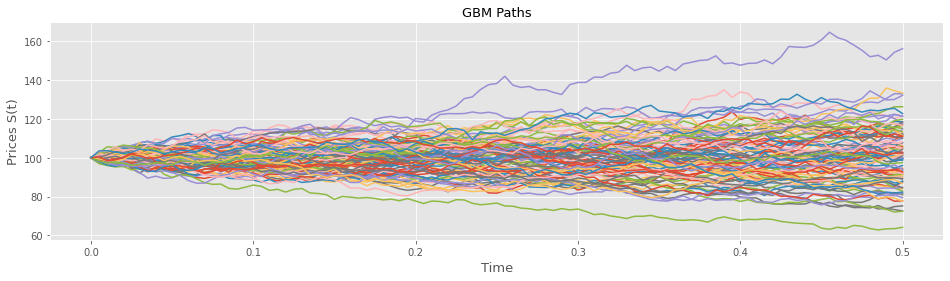

In [8]:
plt.plot(stock_prices_paths['time'], stock_prices_paths['paths'].T);
plt.xlabel("Time", fontsize=13)
plt.ylabel("Prices S(t)", fontsize=13)
plt.title("GBM Paths", fontsize=13)
plt.show()

#### Monte Carlo approach

In [9]:
def digital_option_Monte_Carlo(is_option, S_0, K, r, t, T, sigma, num_paths, num_steps):
    
    paths = GBM_paths(num_paths, num_steps, S_0, r, t, T, sigma)
    time = paths['time']
    ST = paths['paths'][:, -1]
    
    if (is_option == option_type.Call):
        call_payoff = [K if s > K else 0 for s in ST]
        mc_price  = np.exp(-r * (T-t)) * (np.sum(call_payoff) / num_paths)
    elif (is_option == option_type.Put):
        put_payoff = [K if s < K else 0 for s in ST]
        mc_price = np.exp(-r * (T-t)) * (np.sum(put_payoff) / num_paths)
    
    
    return mc_price

#### Compare Estimation vs True price

We will estimate a digital in-the-money call option using Monte Carlo and compare it with the true value computed early. 

For that, we choose the actual stock price $S_0 = 100$ and strike price $K = 95$.

In [10]:
is_option = option_type.Call
K = 95
num_paths = 2500
num_steps = 100
digital_mc_call_price = digital_option_Monte_Carlo(is_option, S_0, K, r, t, T, sigma, num_paths, num_steps)
print(f"Estimated in-the-money digital call price: {np.round(digital_mc_call_price, 3)}")
print(f"True in the money call price: {np.round(call_option_prices[1][0], 3)}")
    

Estimated in-the-money digital call price: 60.87
True in the money call price: 60.811


#### Convergence of the Monte Carlo Estimate to the True Value

In [11]:
num_paths_list = np.arange(100, num_paths + 100, 100)
mc_call_prices = [digital_option_Monte_Carlo(is_option, S_0, K, r, t, T, sigma, num_path, num_steps) for num_path in num_paths_list]

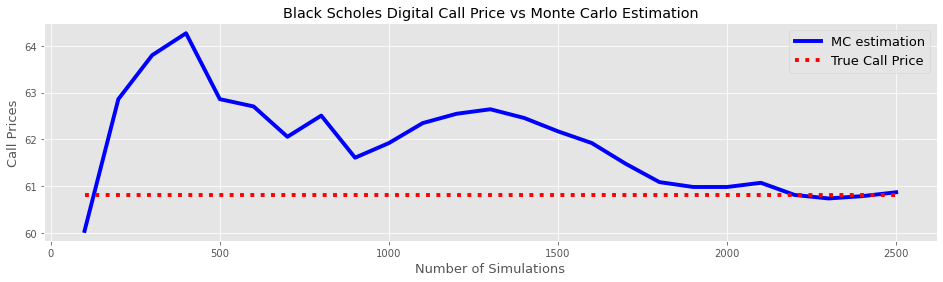

In [12]:
plt.plot(num_paths_list, mc_call_prices, color='b', linewidth = 3.9, label='MC estimation')
plt.plot(num_paths_list, [np.round(call_option_prices[1][0], 3)]*len(num_paths_list), linewidth = 3.9, linestyle = 'dotted', color='r', label='True Call Price')
plt.legend(fontsize=13)
plt.title("Black Scholes Digital Call Price vs Monte Carlo Estimation")
plt.xlabel("Number of Simulations", fontsize=13)
plt.ylabel("Call Prices", fontsize=13)
plt.show()